# [E-16] Movielens - SBR

> 목차
-


**1. 개요**  
    
    1.1 프로젝트 과정 및 목표  

**2. 루브릭 평가기준**  

**3. Project**
    
    3.1 데이터 전처리    
    3.2 미니 배치의 구성  
    3.3 모델 구성  
    3.4 모델 학습
**4. 회고**
    
    4.1 결과 평가  
    4.2 어려웠던 점
    

---
> **1. 개요**
-

> **1.1 프로젝트 과정 및 목표**

**<프로젝트 과정>**
1. 데이터 전처리    
2. 미니 배치의 구성  
3. 모델 구성  
4. 모델 학습
5. 모델 테스트

---
> **2. 루브릭 평가기준**
-

|평가문항 | 상세기준|
|:---------|:---------|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. | 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. | 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.| 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

---
> **3. Project**
-

> 3.1. 데이터 전처리    

In [1]:
# 데이터로드
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [3]:
import datetime
for i in range(1000209):
    data['Time'][i] = datetime.datetime.fromtimestamp(int(data['Time'][i]))
    

In [4]:
data['Time']

0          2000-12-31 22:12:40
1          2000-12-31 22:35:09
2          2000-12-31 22:32:48
3          2000-12-31 22:04:35
4          2001-01-06 23:38:11
                  ...         
1000204    2000-04-26 02:35:41
1000205    2000-04-25 23:21:27
1000206    2000-04-25 23:19:06
1000207    2000-04-26 02:20:48
1000208    2000-04-26 02:19:29
Name: Time, Length: 1000209, dtype: object

In [5]:
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [7]:
# UserID Length
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [9]:
user_length.min(), user_length.max()

(20, 2314)

In [10]:
user_length.quantile(0.999)

1343.181000000005

In [11]:
user_session = user_length[user_length==2314].index[0]
data[data['UserId']==user_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


짧은 간격으로 평가함을 볼 수 있다. 이런 경우는 도움이 안될꺼라 판단되서 제거하고 가야될것 같다.

In [12]:
user_count = user_length.groupby(user_length).size()
length_percent_cumsum = user_count.cumsum() / user_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

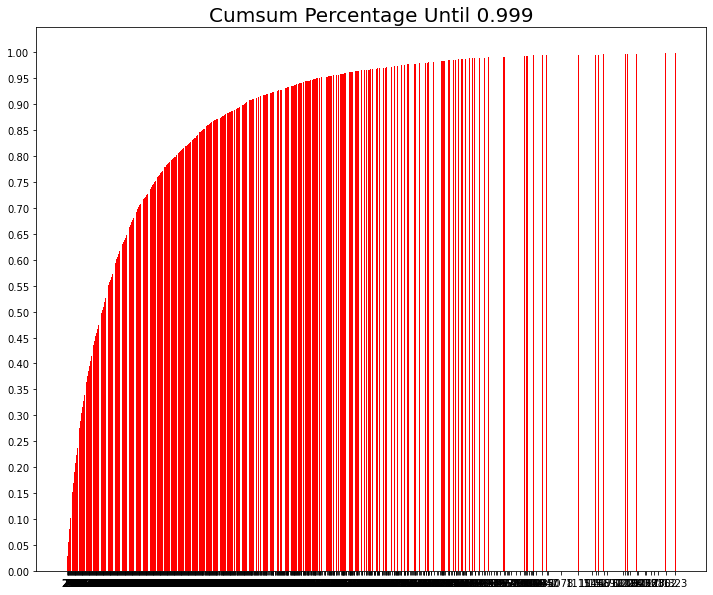

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [14]:
#Session Time
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


대략적으로 3년간의 자료를 수집함을 알 수 있다.

In [15]:
import datetime as dt
month_ago = latest - dt.timedelta(900)
# data = data[data['Time'] >= month_ago]   # 2년간의 데이터를 가진다
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [16]:
# Data Cleansing
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=100, least_click=50)
data

,UserId,ItemId,Rating,Time
130,2,1198,4,2000-12-31 21:28:44
64,2,1210,4,2000-12-31 21:29:11
71,2,1217,3,2000-12-31 21:29:11
134,2,2717,3,2000-12-31 21:29:56
88,2,1293,5,2000-12-31 21:31:01
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


> 3.2. 미니 배치의 구성

In [18]:
# Train / Valid / Test split
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    UserId_last_time = data.groupby('UserId')['Time'].max()
    UserId_in_train = UserId_last_time[UserId_last_time < final_time - dt.timedelta(n_days)].index
    UserId_in_test = UserId_last_time[UserId_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(UserId_in_train)]
    after_date = data[data['UserId'].isin(UserId_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=350)
tr, val = split_by_date(tr, n_days=350)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 533331
	 Sessions: 2136
	 Items: 2423
	 First Time : 2000-04-25 23:25:58
	 Last Time : 2001-03-27 20:17:51

* valid Set Stats Info
	 Events: 109633
	 Sessions: 332
	 Items: 2423
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-15 13:18:32

* test Set Stats Info
	 Events: 174590
	 Sessions: 419
	 Items: 2423
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

> 3.3. 모델 구성

In [25]:
# UserDataset
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2000-12-31 21:28:44,0
64,2,1210,4,2000-12-31 21:29:11,1
71,2,1217,3,2000-12-31 21:29:11,2
134,2,2717,3,2000-12-31 21:29:56,3
88,2,1293,5,2000-12-31 21:31:01,4
170,2,2943,4,2000-12-31 21:32:52,5
106,2,1225,5,2000-12-31 21:33:11,6
120,2,1193,5,2000-12-31 21:33:33,7
172,2,318,5,2000-12-31 21:33:33,8
70,2,3030,4,2000-12-31 21:33:54,9


In [27]:
tr_dataset.click_offsets

array([     0,    128,    315, ..., 533009, 533209, 533331], dtype=int32)

In [28]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2133, 2134, 2135])

In [29]:
# SessionDataLoader
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=64):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters]+1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=64)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2000-12-31 21:28:44,0
64,2,1210,4,2000-12-31 21:29:11,1
71,2,1217,3,2000-12-31 21:29:11,2
134,2,2717,3,2000-12-31 21:29:56,3
88,2,1293,5,2000-12-31 21:31:01,4
170,2,2943,4,2000-12-31 21:32:52,5
106,2,1225,5,2000-12-31 21:33:11,6
120,2,1193,5,2000-12-31 21:33:33,7
172,2,318,5,2000-12-31 21:33:33,8
70,2,3030,4,2000-12-31 21:33:54,9


In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0    3    1  379  416    0  638  771  835   44   14    7 1177 1199
  717 1327   68    7  993  638  116   44 1614  182   28 1802  149  569
  116  354  428  910 1645 1174  570  167 1608  182    7    7  966   60
  717   31  253 1499    0   42   87    7   28  561 1714   14  253  443
 1047  443  842 1151  253  820 1425 1308]
Label Item Idx are :       [   1  128  295  380  425  492  444    0    7  908 1006 1163 1178 1179
  311 1328 1347   85   31 1399 1559 1093  383  992  667  116  581  598
 1842 1537  381  253  230 1491 1814   77  253 1977  600   14   22  444
 1063  128  638   44 1962  311  569  381 1120 1150    1   31  638   26
   28 1448   39  383  374   28  999   22]
Previous Masked Input Idx are []


In [33]:
# Evaluation Metric
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
# Model Architecture
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k


In [37]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=100)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 2423)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      371250    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 2423)                123573    
Total params: 494,823
Trainable params: 494,823
Non-trainable params: 0
_________________________________________________________________


In [49]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size) # args.batch_size , input_ohe
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

> 3.4. 모델 학습

In [40]:
# # 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  85%|████████▍ | 1444/1707 [23:45<04:19,  1.01it/s]


	 - Recall@100 epoch 1: 0.473522
	 - MRR@100    epoch 1: 0.054365



Evaluation:  85%|████████▍ | 1444/1707 [21:25<03:54,  1.12it/s]


	 - Recall@100 epoch 2: 0.563063
	 - MRR@100    epoch 2: 0.077711



Evaluation:  85%|████████▍ | 1444/1707 [19:45<03:35,  1.22it/s]racy=0.0469, train_loss=5.46]


	 - Recall@100 epoch 3: 0.592246
	 - MRR@100    epoch 3: 0.088557



Evaluation:  85%|████████▍ | 1444/1707 [19:22<03:31,  1.24it/s]


	 - Recall@100 epoch 4: 0.603434
	 - MRR@100    epoch 4: 0.094317



Evaluation:  85%|████████▍ | 1444/1707 [19:14<03:30,  1.25it/s]


	 - Recall@100 epoch 5: 0.608953
	 - MRR@100    epoch 5: 0.097482



Evaluation:  85%|████████▍ | 1444/1707 [19:19<03:31,  1.25it/s]


	 - Recall@100 epoch 6: 0.610381
	 - MRR@100    epoch 6: 0.099528



Evaluation:  85%|████████▍ | 1444/1707 [19:10<03:29,  1.26it/s]


	 - Recall@100 epoch 7: 0.611366
	 - MRR@100    epoch 7: 0.100507



Evaluation:  85%|████████▍ | 1444/1707 [19:10<03:29,  1.25it/s]


	 - Recall@100 epoch 8: 0.610987
	 - MRR@100    epoch 8: 0.100530



Evaluation:  85%|████████▍ | 1444/1707 [19:13<03:30,  1.25it/s]


	 - Recall@100 epoch 9: 0.610598
	 - MRR@100    epoch 9: 0.100900



Evaluation:  85%|████████▍ | 1444/1707 [19:15<03:30,  1.25it/s]


	 - Recall@100 epoch 10: 0.608412
	 - MRR@100    epoch 10: 0.101343



> **4. 회고**
-

> 4.1 결과 평가

훈련을 열번 돌렸는데   
accuracy=0.0781, train_loss=5.5  
	 - Recall@100 epoch 10: 0.608412
	 - MRR@100    epoch 10: 0.101343  
의 결과가 나와서 훈련이 제대로 안된것같다..

> 4.2 어려웠던 점

기존 노드랑 비교해서 따라해봤는데 안되는 부분이 많아서 제대로 된 결과가 안나왔습니다...